In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from keras.callbacks import ReduceLROnPlateau

def quantile_loss(i):
  def loss(y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(i * e, (i - 1) * e))
  return loss

X = pd.read_csv("Xtable.csv")
y= X.iloc[:,-1].values
X = X.iloc[:,1:].values

window_size = 50;
step_size = 15;

X_win_all = []
y_win_all = []

for i in range(0,len(X)-window_size-15+1,step_size):
  X_win = X[i:i+window_size]
  y_win = y[i+window_size:i+window_size+15]
  X_win_all.append(X_win)
  y_win_all.append(y_win)

X_win_all=np.array(X_win_all)
y_win_all=np.array(y_win_all)

# Although called val, all variables with val is for testing, because we train a model from scratch in every walk
X_trainval = X_win_all[:]
y_trainval = y_win_all[:]

# Walk forward Validation
shift_win = 1

# In a single walk
n_train = 10
n_valid = 1

pred_train_all = []
pred_val_all = []

true_train_all = []
true_val_all = []

rmse_train_per_walk = []
rmse_val_per_walk = []

train_idx_all = []
val_idx_all = []

hist_tr_loss = []

# Coloumns to be normalized
cols_N = np.concatenate([np.arange(8,37),np.array([38,39,41,42,44,45,47,48,50,51,53,54,56,57,58])])

for start_idx in range(0, len(X_trainval)-n_train-n_valid+1,shift_win):

  X_train = X_trainval[start_idx:start_idx+n_train].copy()
  y_train = y_trainval[start_idx:start_idx+n_train].copy()

  X_val = X_trainval[start_idx+n_train:start_idx+n_train+n_valid]
  y_val = y_trainval[start_idx+n_train:start_idx+n_train+n_valid]

  # Normalization
  normalizer_y = StandardScaler()
  normalizer_X = {}

  for k in cols_N:
    scaler_X = StandardScaler()
    X_train[:,:,k] = scaler_X.fit_transform(X_train[:,:,k])
    normalizer_X[k] = scaler_X

  normalizer_y.fit_transform(y_train.flatten().reshape(-1,1))
  y_train = normalizer_y.transform(y_train.flatten().reshape(-1,1)).reshape(-1,15)

  for k in cols_N:
    X_val[:,:,k] = normalizer_X[k].transform(X_val[:,:,k])

  y_val = normalizer_y.transform(y_val.flatten().reshape(-1, 1)).reshape(-1, 15)

 # fitting

  mdl = Sequential([
      GRU(
        units=150,
        input_shape=[window_size,X_train.shape[2]],
        activation='tanh',
        return_sequences=True
      ),
      GRU(
        units=150,
        activation='tanh',
      ),
      Dropout(0.2),
      Dense(15)
  ])

  mdl.compile(optimizer=Adam(learning_rate=0.01),loss=Huber(delta=1))

  hist = mdl.fit(X_train,
                 y_train,
                 epochs=15,
                 shuffle=False,
                 batch_size=20)

  hist_tr_loss.append(hist.history['loss'])

  train_pred = mdl.predict(X_train)
  val_pred  = mdl.predict(X_val)

  train_pred = normalizer_y.inverse_transform(train_pred)
  val_pred = normalizer_y.inverse_transform(val_pred)

  true_train = normalizer_y.inverse_transform(y_train)
  true_val = normalizer_y.inverse_transform(y_val)

  pred_train_all.append(train_pred)
  pred_val_all.append(val_pred)

  true_train_all.append(true_train)
  true_val_all.append(true_val)

  time_idx = start_idx * step_size + window_size
  train_idx = list(range(time_idx, time_idx + n_train * 15))
  val_idx = list(range(time_idx + n_train * 15, time_idx + (n_train + n_valid) * 15))

  train_idx_all.append(train_idx)
  val_idx_all.append(val_idx)

  rmse_train_per_walk.append(np.sqrt(mean_squared_error(train_pred,true_train)))
  rmse_val_per_walk.append(np.sqrt(mean_squared_error(val_pred,true_val)))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.3798
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.3513
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.4265
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2114
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1225
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1581
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0940
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1259
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1162
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0754
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0555
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0748
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0909
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0830
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0703
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4648
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2379
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.4637
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1624
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1209
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1031
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1281
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1053
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0924
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0886
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0679
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0741
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0507
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0720
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5247
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.5732
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.6824
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3623
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.1456
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1936
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.1318
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.1497
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1117
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0913
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1062
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.1076
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0954
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0792
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3946
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.7152
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 1.0600
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4874
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2143
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2387
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2404
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.1773
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1393
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1347
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1755
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1069
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0952
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0894
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5153
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.7568
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.8512
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.5615
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1984
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.2275
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2335
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2297
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1213
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1780
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1617
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.1250
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0960
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1026
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4166
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.8683
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 1.0075
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.4627
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3160
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.3029
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.3106
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1755
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.1820
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1702
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1423
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.1200
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0935
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1197
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.1206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4402
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.7067
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.3968
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.4973
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2949
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2934
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2130
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1765
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1633
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1336
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1517
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1509
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0977
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1071
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4824
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.6649
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.9791
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.3480
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3904
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2394
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2012
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1877
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1737
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0979
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1143
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1140
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0758
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1060
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0772
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4444
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.7470
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.8172
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.3992
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.2243
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1737
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1764
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.1410
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.1240
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.1212
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1323
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0906
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0959
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0879
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4807
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1827
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3410
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.3604
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2562
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1131
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1356
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0968
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.0982
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1017
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0856
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0793
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0747
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0887
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4722
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.4114
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.4410
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.2984
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1453
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1756
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1186
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1069
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1403
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1056
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1297
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0934
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0753
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1001
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5638
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.2469
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.4425
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1980
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2053
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.1456
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.1221
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1181
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0981
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.1223
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0806
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0986
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0685
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0666
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0646
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4484
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.4998
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5066
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2499
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1980
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1367
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1067
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1092
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1094
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1117
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1204
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0997
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0701
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0730
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4179
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.4432
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.7257
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2602
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1625
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1521
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1570
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1078
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1422
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0916
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0852
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0726
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0920
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0986
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0954
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4892
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.4352
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.4539
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.3318
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.1991
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.1821
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1499
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.1216
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.1228
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0953
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1075
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0965
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0779
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0830
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0960
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4926
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2823
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3446
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.6799
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1608
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.1678
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.1271
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1476
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1103
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1071
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1073
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0771
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0811
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0925
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5330
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2963
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2676
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2792
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1817
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1015
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1479
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0964
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0888
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1093
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0927
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0879
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0879
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0923
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0672
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4750
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.3124
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3773
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2292
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1481
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1481
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1308
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1172
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0979
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1046
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.1118
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.1025
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0855
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0702
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0615
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5000
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3822
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.6350
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.2674
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1377
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1711
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1270
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0824
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1021
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1039
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1015
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0640
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0524
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0897
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4974
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2546
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.8175
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.4021
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1970
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1445
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1165
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1194
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1243
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0877
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0982
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0920
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0930
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0790
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4722
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2830
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.6754
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3051
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1275
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1278
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1274
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1372
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0980
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1189
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1046
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0852
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0624
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0717
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0758
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5086
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.6480
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.7178
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2820
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1939
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2015
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1734
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1293
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1572
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1368
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1507
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1108
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1270
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1159
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1027
1/1 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4539
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.3271
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.2213
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.2184
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2655
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2094
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1310
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1598
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1108
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0760
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1043
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0849
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0775
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0653
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4651
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4390
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3176
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.3322
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.1821
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1870
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1270
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1143
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0983
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0878
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0814
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.1134
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0837
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0699
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0777
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4745
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.4075
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.2824
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2360
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1950
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1210
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1637
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1479
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0950
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1079
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1100
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1093
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0826
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0725
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4765
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.4098
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3079
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3994
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1761
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1534
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1573
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1172
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1057
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1134
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1015
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0812
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0801
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1048
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0749
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4234
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3339
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3736
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.2839
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1736
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1746
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1605
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1133
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0980
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.1000
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0881
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0924
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.0743
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0747
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0779
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4376
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.3166
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3173
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2443
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1547
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.1039
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0869
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0967
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0926
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0966
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0845
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0998
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0762
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0674
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4555
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3126
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2214
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1537
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1968
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1911
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1363
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1341
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1005
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1042
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0767
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0649
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0655
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.0623
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4369
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.3508
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3643
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.2609
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1314
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0829
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1051
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1099
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1066
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0880
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0897
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0829
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0775
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0677
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5228
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2843
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.2643
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2313
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1764
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0941
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1279
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0881
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1035
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0701
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0825
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1148
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.0629
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.0535
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0676
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5302
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2860
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.5899
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3265
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1588
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1049
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1265
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1203
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1094
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0875
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0813
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0848
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0728
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0763
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.5570
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.4879
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.9948
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.4023
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1216
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2152
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.1799
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1605
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1336
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.1437
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1094
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0750
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1020
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0821
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4707
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2725
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.4737
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.3551
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.2057
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.1480
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1256
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1103
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1203
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1135
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0827
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.0955
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0747
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0796
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0846
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4904
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3880
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.3044
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2166
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1749
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1321
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1212
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0997
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0833
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0900
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0828
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0772
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0757
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0708
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4128
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.3084
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3446
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.5358
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2441
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.1478
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1540
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1374
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.1071
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0911
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0863
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0868
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0656
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0853
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0860
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4520
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.4069
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.2787
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3337
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.2818
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.2280
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1776
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1375
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1141
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0795
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0834
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0912
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.1058
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0919
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0820
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4325
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.4783
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.3117
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.2986
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1689
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1909
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1428
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1192
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0921
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0831
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0789
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0800
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0669
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.0652
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0821
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4323
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.3661
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2196
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.3407
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2210
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1549
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.1119
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1124
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1245
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.1071
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0797
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0972
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0875
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0733
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4447
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.3265
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.3933
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2620
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.1360
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1261
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.1063
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1226
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1228
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0924
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0973
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0956
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0987
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0859
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4316
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2918
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.4084
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.2387
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.1560
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.1882
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1432
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1195
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1204
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.1037
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0589
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0798
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0664
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0774
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0779
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4921
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.2885
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.4274
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2305
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1539
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1153
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1513
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.0855
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0919
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0748
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0849
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0957
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0875
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0680
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.0620
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4617
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.3328
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.5934
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.3368
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1605
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1263
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.1112
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1095
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0865
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0883
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0789
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0896
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.0950
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0673
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.4108
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - loss: 0.6926
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.6829
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - loss: 0.3725
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step - loss: 0.1156
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.1781
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.1461
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.1111
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1281
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1539
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1305
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0682
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.1005
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0934
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4793
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.2349
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.4946
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2495
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1942
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1247
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1114
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.1306
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0671
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0901
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0787
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0987
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0634
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0495
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.0632
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4619
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1871
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.5741
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.3056
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1674
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1250
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1130
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.1071
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0996
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0812
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0919
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0856
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0735
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0919
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4608
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2894
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.4219
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2097
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.1583
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1258
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1245
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1000
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0773
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0757
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1041
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1011
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0747
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0579
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4762
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.2446
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.5761
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2129
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 0.2502
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.1657
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.0902
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0976
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.1170
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0842
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0945
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0957
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.1014
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.1120
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0839
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4848
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2868
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3480
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2033
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1493
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1429
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1307
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1161
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0907
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0870
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0729
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0862
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0587
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0774
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4374
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2752
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3149
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.2317
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1499
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.1003
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1243
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1268
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0936
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1140
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0881
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0829
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0770
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0878
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4452
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.3413
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.4777
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.2920
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.1305
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1686
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.1302
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.1021
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0854
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0815
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.1041
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0670
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0656
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0833
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1058
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4536
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3546
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.7438
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.3564
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1551
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.1137
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.1291
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0912
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 0.1113
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.1035
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0799
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1035
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.1003
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0856
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0735
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4893
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.3342
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.3735
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.3363
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1513
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1108
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0765
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0970
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0827
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1011
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0808
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0807
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0627
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0610
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0772
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4395
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.4282
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 0.3218
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.2193
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - loss: 0.1480
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.1052
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.1039
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 0.1148
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0893
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0958
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0920
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0768
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0593
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0745
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4440
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 0.3799
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2509
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.2203
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1489
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1443
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1187
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1263
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0986
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0937
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0989
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0951
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0978
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0888
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.0836
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4406
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.5007
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2905
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.2072
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.2273
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.1584
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1469
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.1372
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0961
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.1034
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0887
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0828
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0955
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0586
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0476
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms

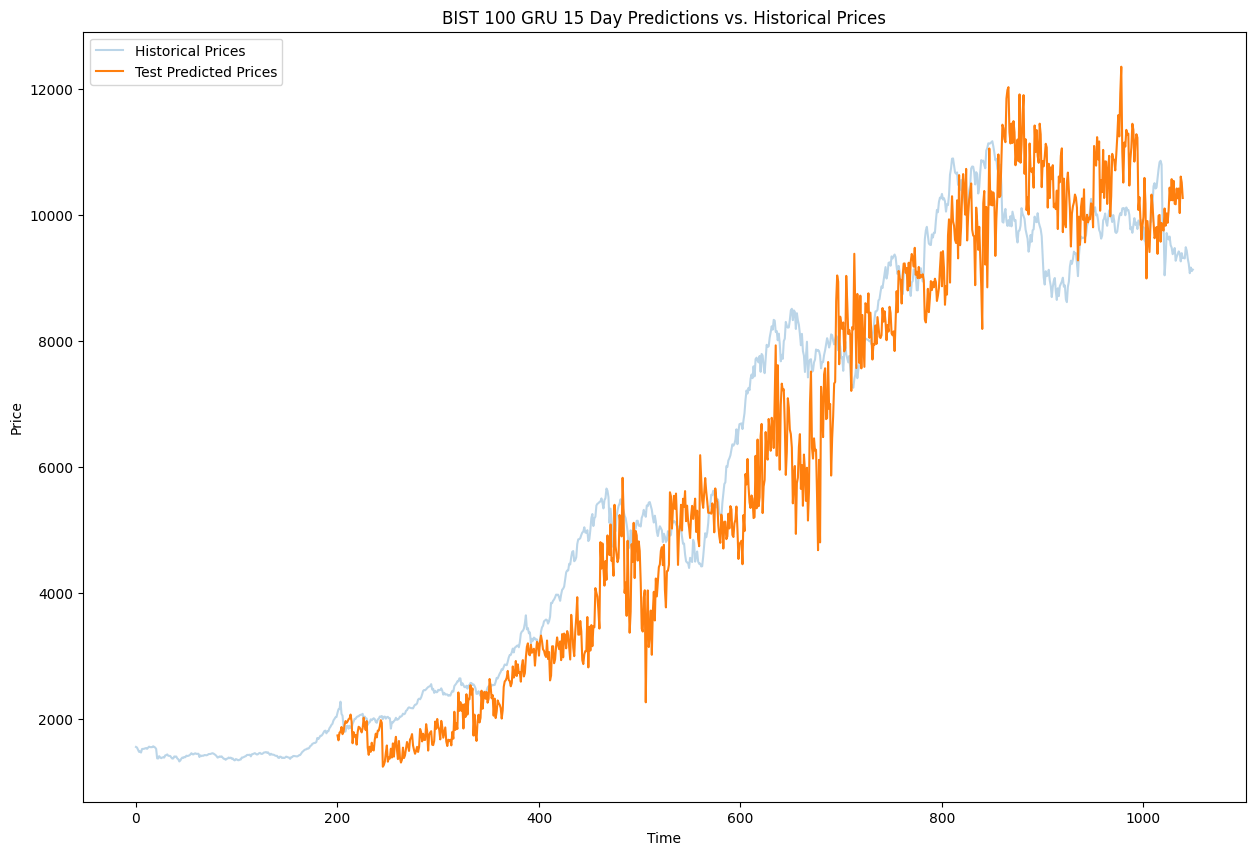

In [11]:
plt.figure(figsize=(15,10))
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat.reshape(-1,1) - pred_val_all_flat.reshape(-1,1)

val_idx_all_flat = np.concatenate([p.flatten() for p in np.array(val_idx_all)])

plt.plot(range(len(y)),y, label='Historical Prices', alpha=0.3)
plt.plot(val_idx_all_flat, pred_val_all_flat, label='Test Predicted Prices')

plt.title('BIST 100 GRU 15 Day Predictions vs. Historical Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



In [12]:
pred_err_val = []
true_err_val = []

for i in range(len(pred_val_all)):
  idx = [idx for idx in val_idx_all[i] if idx < len(y)]
  pred_err_val.extend(pred_val_all[i].flatten()[:len(idx)])
  true_err_val.extend(y[idx])

rmse_val_err = np.sqrt(mean_squared_error(pred_err_val,true_err_val))
r2_val_err = r2_score(pred_err_val,true_err_val)
mae_val_err = mean_absolute_error(pred_err_val,true_err_val)
mape_val_err = mean_absolute_percentage_error(pred_err_val,true_err_val)
acc_val_err = (1-mae_val_err/np.mean(true_err_val))*100

pred_err_train = []
true_err_train = []

for i in range(len(pred_train_all)):
  idx = [idx for idx in train_idx_all[i] if idx < len(y)]
  pred_err_train.extend(pred_train_all[i].flatten()[:len(idx)])
  true_err_train.extend(y[idx])

rmse_train_err = np.sqrt(mean_squared_error(pred_err_train,true_err_train))
r2_train_err = r2_score(pred_err_train,true_err_train)
mae_train_err = mean_absolute_error(pred_err_train,true_err_train)
mape_train_err = mean_absolute_percentage_error(pred_err_train,true_err_train)
acc_train_err = (1-mae_train_err/np.mean(true_err_train))*100

print(f"TRAIN RMSE: {rmse_train_err}")
print(f"TRAIN R2: {r2_train_err}")
print(f"TRAIN MAE: {mae_train_err}")
print(f"TRAIN MAPE: {mape_train_err}")
print(f"TRAIN ACC: {acc_train_err}")

print(f"TEST RMSE: {rmse_val_err}")
print(f"TEST R2: {r2_val_err}")
print(f"TEST MAE: {mae_val_err}")
print(f"TEST MAPE: {mape_val_err}")
print(f"TEST ACC: {acc_val_err}")

TRAIN RMSE: 209.57130246953744
TRAIN R2: 0.9955001631155745
TRAIN MAE: 144.45010998128254
TRAIN MAPE: 0.030962503286941046
TRAIN ACC: 97.48977566992684
TEST RMSE: 1042.1123697213627
TEST R2: 0.9030076085272709
TEST MAE: 840.0230826590401
TEST MAPE: 0.17816088732563468
TEST ACC: 87.19729140461824


In [13]:
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat.reshape(-1,1) - pred_val_all_flat.reshape(-1,1)

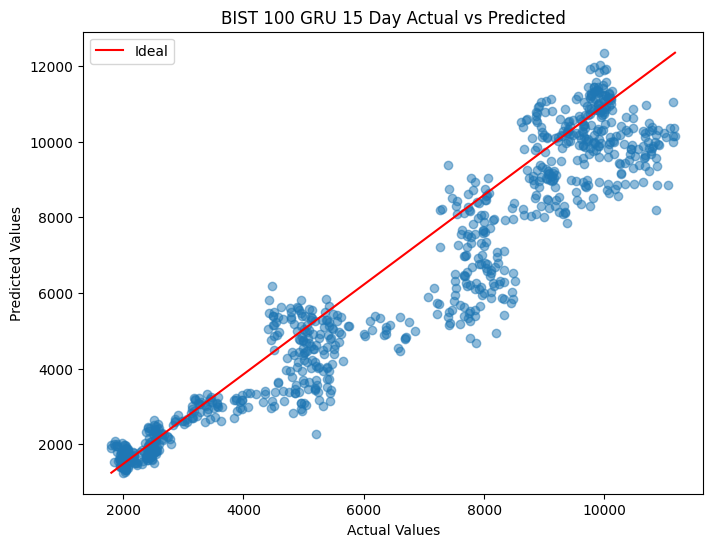

In [14]:
plt.figure(figsize=(8,6))

plt.scatter(true_val_all_flat, pred_val_all_flat, alpha=0.5)
plt.plot([min(true_val_all_flat),max(true_val_all_flat)],[min(pred_val_all_flat),max(pred_val_all_flat)],"r", label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("BIST 100 GRU 15 Day Actual vs Predicted")
plt.legend()
plt.show()

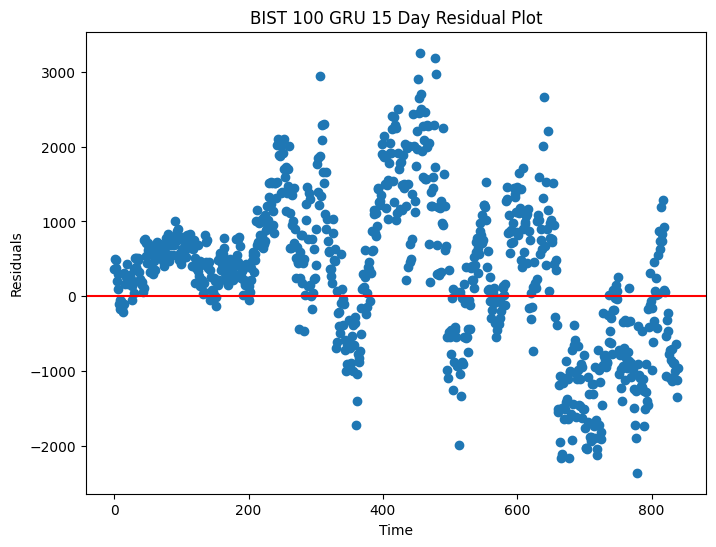

In [15]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res)),res)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 GRU 15 Day Residual Plot")
plt.show()

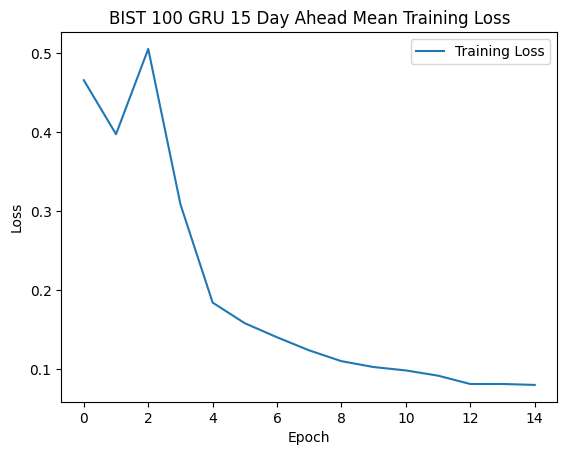

In [16]:
hist_tr_loss = np.array(hist_tr_loss)

hist_tr_loss_mean = np.mean(hist_tr_loss, axis=0)

plt.plot(hist_tr_loss_mean, label='Training Loss')
plt.title('BIST 100 GRU 15 Day Ahead Mean Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()